In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Fixed trigger

Use an exponential decay in time, and Gaussian in space, and see what background we can fit to the Chicago data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_fixed
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.naive
import sepp.sepp_full

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [4]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

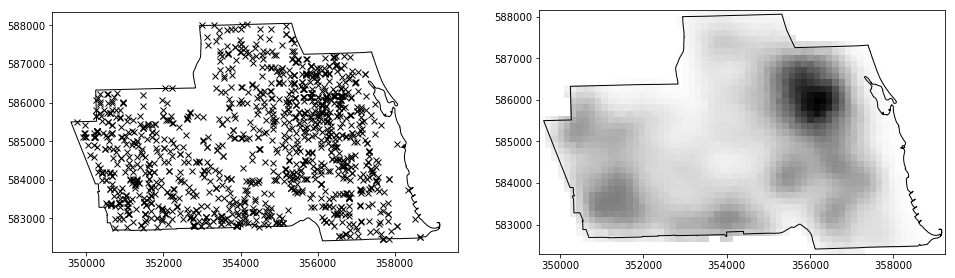

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

# Train

In [9]:
tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
bkp = sepp.sepp_full.FixedBandwidthKernelProvider(50)
trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
trainer.data = points
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
model

KDEModel(T=730.9583333333334, mu=1.5333367114403285, background=<open_cp.kernels.GaussianBase object at 0x00000285AAFBA908>, theta=0.08803478679150782, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)

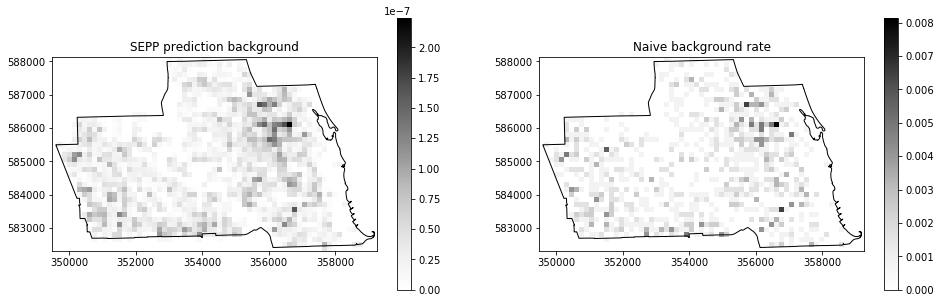

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)

ax = axes[0]
pred = open_cp.predictors.KernelRiskPredictor(model.background_kernel)
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)
ax.set_title("SEPP prediction background")

naive = open_cp.naive.CountingGridKernel(grid.xsize, grid.ysize, grid.region())
naive.data = points
pred = naive.predict().renormalise()
ax = axes[1]
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)
ax.set_title("Naive background rate")

None

### Speed of convergence

In [12]:
trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(100):
    opt = trainer._optimiser(model, data)
    old_model = model
    model = opt.iterate()
    print(model, np.mean((model.mu - old_model.mu)**2), (model.theta - old_model.theta)**2)

KDEModel(T=730.9583333333334, mu=1.3461571798638865, background=<open_cp.kernels.GaussianBase object at 0x00000285ADAF55F8>, theta=0.19936142506264662, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.112357167246 0.0903835527404
KDEModel(T=730.9583333333334, mu=1.4694671299742563, background=<open_cp.kernels.GaussianBase object at 0x00000285AAFCD2E8>, theta=0.12602177037095275, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.0152053437962 0.0053787049503
KDEModel(T=730.9583333333334, mu=1.5054754850500678, background=<open_cp.kernels.GaussianBase object at 0x00000285ADABDF60>, theta=0.10460549110952884, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.00129660163527 0.000458657017403
KDEModel(T=730.9583333333334, mu=1.5198691904477066, background=<open_cp.kernels.GaussianBase object at 0x00000285ADABD898>, theta=0.0960447108752333, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.000207178755074 7.32869582199e-05
KDEModel(T=730.9583

## Dependence on parameters

In [25]:
bandwidths = np.linspace(20,300,50)
models = dict()
for bw in bandwidths:
    tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
    sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
    bkp = sepp.sepp_full.FixedBandwidthKernelProvider(bw)
    trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
    trainer.data = points
    models[bw] = trainer.train(datetime.datetime(2018,1,1), iterations=20)

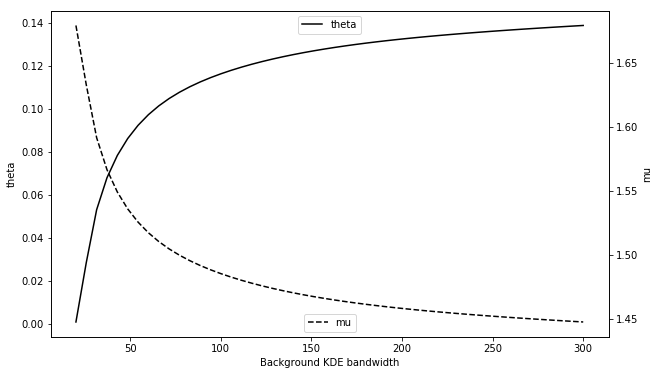

In [40]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bandwidths, [models[bw].theta for bw in bandwidths], label="theta", color="black", linestyle="-")
ax.set(ylabel="theta", xlabel="Background KDE bandwidth")
ax.legend(loc="upper center")
ax1 = ax.twinx()
ax1.plot(bandwidths, [models[bw].mu for bw in bandwidths], label="mu", color="black", linestyle="--")
ax1.set(ylabel="mu")
ax1.legend(loc="lower center")
None

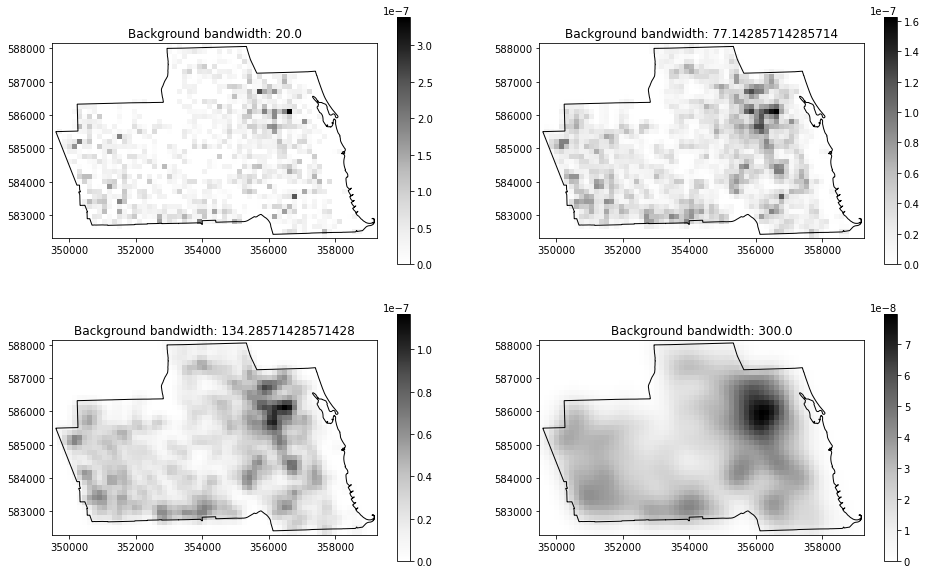

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

for ax, i in zip(axes.flat, [0,10,20,-1]):
    bw = bandwidths[i]
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    pred = open_cp.predictors.KernelRiskPredictor(models[bw].background_kernel, samples=-5)
    pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)
    ax.set_title("Background bandwidth: {}".format(bw))